In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.sans-serif"] = ["SimHei"]  #设置字体
plt.rcParams["axes.unicode_minus"] = False  #该语句解决图像中的“-”负号的乱码问题
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import os

os.chdir(r'D:\pycharm-python\datasets')
import seaborn as sns

import seaborn as sns
sns.set_style('whitegrid',{'font.sans-serif':['SimHei','Arial']})
from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn import metrics
import scipy

In [2]:
def load_data():
    df = pd.read_csv(r'0219城市数据.csv')
    df = df.drop(['Unnamed: 9','Unnamed: 10'], axis=1)
    new_df = df.dropna()
    arr = np.array(new_df)[:, 2:]
    x = arr[:, :-1].copy()
    y = arr[:, -1:].copy()
    return df, x, y

In [3]:
df, x, y = load_data()

In [7]:
# df = df.dropna()
df

,省份,城市,VIIRS（W）,总gdp（亿元）,人口密度（平方公里/人）,城镇化率（%）,汽车保有量（万辆）,总用电量（亿千瓦时）,光污染程度
0,上海市,黄浦区,788.15,2270.31,32000.0,100.00,26.0900,16.75,11747.519700
1,天津市,南开区,447.95,580.57,28700.0,100.00,11.1319,27.31,10222.588510
2,重庆市,渝中区,310.49,362.38,28000.0,93.18,4.1205,5.50,9912.548358
3,北京市,东城区,381.47,361.37,19600.0,100.00,10.9300,48.05,6990.236548
4,广东省,深圳市,2329.18,2423.78,8341.2,100.00,347.1300,917.23,3885.901685
...,...,...,...,...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 建立回归模型之前的准备工作：
1. 分析相关系数矩阵
2. 分析显著性检验矩阵

+ 相关稀疏矩阵

In [5]:
# 相关系数矩阵
corr = df.corr()

C:\Users\29236\AppData\Local\Temp\ipykernel_14964\3527500670.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


In [6]:
# 相关系数已经保存为corr_matrix.csv文件
correlation, p_value = scipy.stats.pearsonr(df['城镇化率（%）'], df['光污染程度'])  #相关系数与P-value
correlation, p_value
# corr

ValueError: array must not contain infs or NaNs

In [ ]:
plt.figure(figsize=(10, 8),dpi=150)
sns.heatmap(corr, annot=True, cmap='BuGn')
plt.show()

**显著性检验矩阵**：
显著性检验的目的是为了 将从样本中得到的结论推广到总体中，通过“小概率事件是不可能事件”这一原理进行推断。一般而言是对总体做出原假设，然后通过对随机的样本数据对原假设进行分析，判断其与原假设是否存在显著性的差异。

In [34]:
# 显著性检验矩阵、

In [159]:
y = y.reshape((y.shape[0],))

In [160]:
cv = KFold(n_splits=4, shuffle=True, random_state=10)

In [161]:
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor(
    n_estimators=64
)

In [162]:
def getNumbers(regressor,cv,x,y):
    r2 = cross_val_score(regressor,x,y,scoring='r2',cv=cv)
    mae = cross_val_score(regressor,x,y,scoring='neg_mean_absolute_error',cv=cv)
    mse = cross_val_score(regressor,x,y,scoring = 'neg_mean_squared_error',cv=cv)
    return r2.mean(),-mae.mean(),-mse.mean()

In [163]:
getNumbers(xgb,cv,x,y)

(0.7807813865430626, 237.82948471512054, 497757.06957549707)

In [164]:
from sklearn.svm import SVR
linear_svc = SVR(kernel='linear')
linear_svc

SVR(kernel='linear')

In [165]:
getNumbers(linear_svc,cv,x,y)

(0.9999999944863399, 0.058872546555036896, 0.007189688727156755)

In [166]:
# from sklearn.svm import
poly_svr = SVR(kernel = 'rbf')
getNumbers(poly_svr,cv,x,y)

(-0.09206779833406925, 598.919632069863, 3467202.232520174)

In [169]:
from sklearn.linear_model import LinearRegression
linreg  = LinearRegression()
getNumbers(linreg,cv,x,y)

(1.0, 1.4561518249827316e-07, 3.3102701151111673e-13)

In [171]:
# linreg.coef_
reg = linreg.fit(x,y)

In [172]:
reg.coef_

array([0.14498, 0.18917, 0.34985, 0.0193 , 0.17983, 0.11686])

AttributeError: 'LinearRegression' object has no attribute 'coef_'

### 进行调参

In [66]:
params_test1 = [
    {'max_depth': range(1,10)}
]
gsearch = GridSearchCV(
    estimator=RandomForestRegressor(
        min_samples_split=1,
        min_samples_leaf=2,
        # max_depth=4,
        max_features='sqrt',
        n_estimators=60,
        random_state=10
    ),
    param_grid=params_test1,
    scoring='r2',
    cv=5,
    return_train_score=True
)

In [67]:
# gsearch.best_score_,gsearch.best_params_

In [69]:
rf = RandomForestRegressor(
    min_samples_split=1,
    min_samples_leaf=2,
    max_features='sqrt',
    n_estimators=60,
    random_state=10,
    max_depth=8,
    oob_score=True
)

In [70]:
rf.fit(x,y)
r2 = cross_val_score(rf,x,y,cv=cv,scoring='r2')
r2

array([0.3447355 , 0.53783373, 0.73281359, 0.79396926])

In [71]:
rf.decision_path(x[:1,:])

(<1x3470 sparse matrix of type '<class 'numpy.int64'>'
 	with 350 stored elements in Compressed Sparse Row format>,
 array([   0,   55,  110,  163,  230,  297,  348,  407,  470,  535,  590,
         645,  704,  761,  818,  869,  928,  993, 1050, 1115, 1166, 1229,
        1284, 1339, 1398, 1437, 1498, 1561, 1618, 1677, 1736, 1801, 1868,
        1933, 1990, 2039, 2094, 2153, 2204, 2273, 2334, 2393, 2454, 2505,
        2556, 2609, 2678, 2739, 2794, 2859, 2912, 2981, 3036, 3101, 3152,
        3203, 3258, 3307, 3344, 3409, 3470]))

In [72]:
r2.mean()

0.6023380198700115

In [73]:
r2.std()
# df

0.17625710684159573

<AxesSubplot: xlabel='GDP', ylabel='DN'>

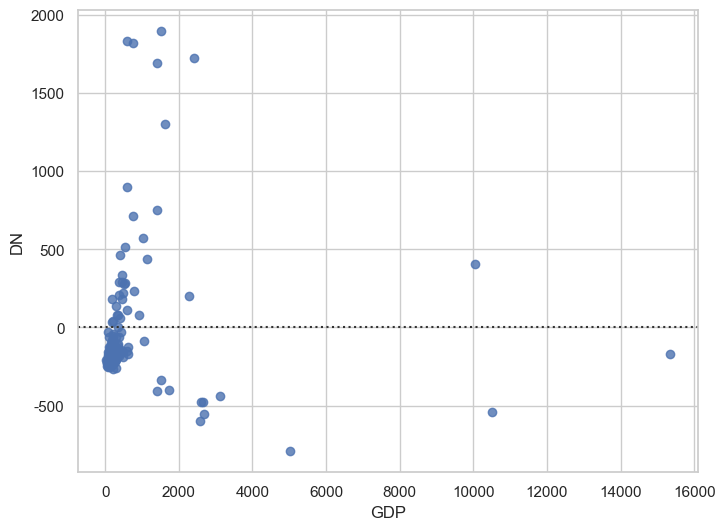

In [74]:
fig = plt.figure(figsize=(8,6))


sns.residplot(data=df.drop(['Province','City'],axis=1),x='GDP',y='DN')


In [75]:
mae = cross_val_score(rf,x,y,scoring='neg_mean_absolute_error',cv=cv)

In [76]:
mae = -mae
mae

array([136.53026715, 295.19319946, 203.52782554, 173.8915485 ])

In [77]:
mae.mean()

202.28571016041172

In [0]:
mae.std()

In [0]:
mse = cross_val_score(rf,x,y,scoring='neg_mean_squared_error',cv=cv)
mse = - mse

In [81]:
mse.mean()

102878.79185437712

In [83]:
importance = rf.feature_importances_

In [84]:
df.head()

,Province,City,GDP,PopDenity,Urban_rate,Cars,Elec,DN
0,重庆市,渝中区,362.38,23222.0,93.18,4.1205,5.50,310.49
1,重庆市,大足区,286.02,1337.0,50.94,4.8136,3.27,31.47
2,重庆市,开州区,131.03,1364.0,44.23,9.9600,12.52,18.16
3,重庆市,城口县,68.37,66.0,30.54,0.9496,1.68,7.15
4,浙江省,杭州市,1404.70,2045.0,85.87,106.0000,335.90,2147.46


In [85]:
importance

array([0.19506651, 0.12837602, 0.16158163, 0.17481339, 0.34016246])

([<matplotlib.patches.Wedge at 0x20531778d60>,
 [Text(1.7996650117781856, 1.2653876265324489, 'GDP'),
  Text(-0.1278532597407455, 2.1962817542322903, 'PopDenity'),
  Text(-1.8135995593826297, 1.2453339464605997, 'Urban_rate'),
  Text(-1.9760809159494652, -0.9670078663694124, 'Cars'),
  Text(1.0588741948477252, -1.928415266348403, 'Elec')],
 [Text(0.9816354609699193, 0.6902114326540629, '19.51%'),
  Text(-0.06973814167677025, 1.1979718659448855, '12.84%'),
  Text(-0.9892361232996161, 0.6792730617057815, '16.16%'),
  Text(-1.0778623177906173, -0.5274588362014976, '17.48%'),
  Text(0.5775677426442137, -1.0518628725536743, '34.02%')])

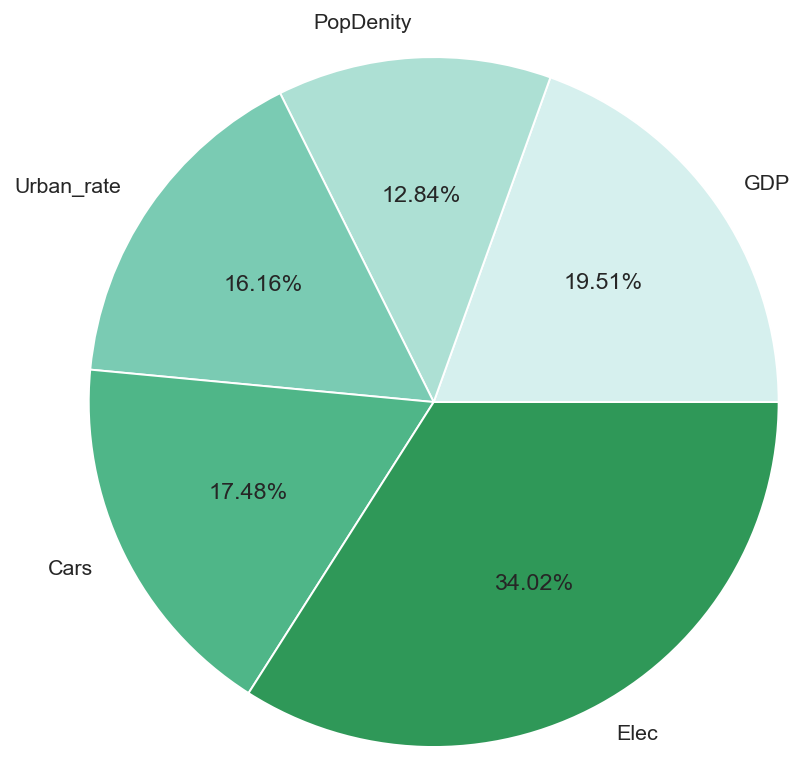

In [88]:
plt.figure(figsize=(4,4),dpi=140)
colors = plt.get_cmap('BuGn')(np.linspace(0.2, 0.7, len(importance)))
plt.pie(x=importance, radius=2, center=(0, 0), autopct='%.2f%%', labels=df.columns.tolist()[2:-1], colors=colors)

([<matplotlib.patches.Wedge at 0x27b86cae410>,
 [Text(0.9878585429071759, 0.48387549969523314, 'Total Night Light'),
  Text(0.07205338741312817, 1.0976376038393973, 'GDP'),
  Text(-1.0982102778750358, -0.06272308641670066, 'PopulationDensity'),
  Text(-0.38133205529922276, -1.0317877027767246, 'UrbanizationRate'),
  Text(0.295076863708852, -1.0596837474000191, 'ElectricityConsumption'),
  Text(1.026697405272148, -0.39483216435270163, 'VehicleOwnship')],
 [Text(0.7364036410762583, 0.360707190681901, '14.50%'),
  Text(0.05371252516251372, 0.8182389410439143, '18.92%'),
  Text(-0.8186658435068447, -0.04675720987426775, '34.99%'),
  Text(-0.2842657139503297, -0.7691508329790128, '1.93%'),
  Text(0.21996638931023507, -0.7899460662436506, '17.98%'),
  Text(0.7653562475665103, -0.29432943160837755, '11.69%')])

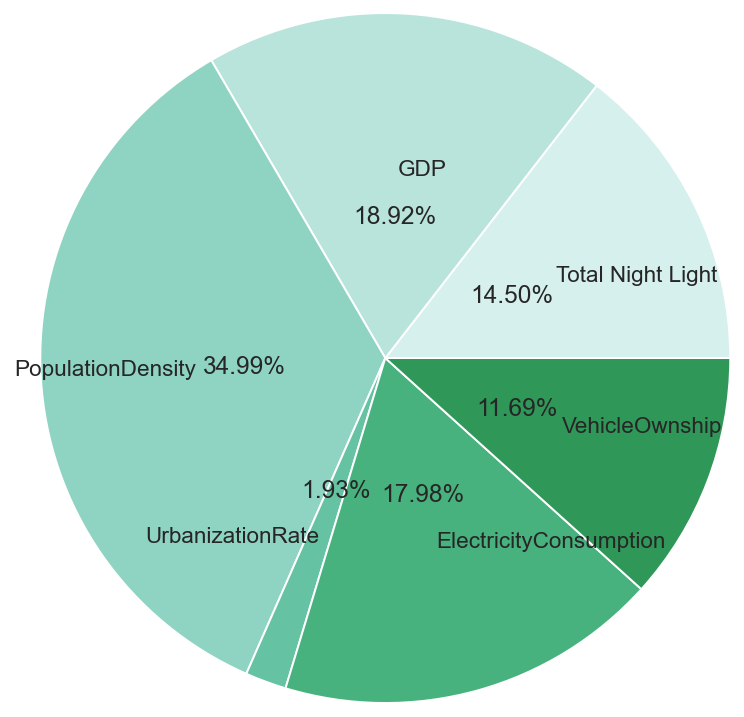

In [26]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
import numpy as np
import pandas as pd
# import seaborn as sns

import seaborn as sns
sns.set_style('whitegrid',{'font.sans-serif':['SimHei','Arial']})
sns.set(font_scale=1.05)
plt.figure(figsize=(4,4),dpi=140)
colors = plt.get_cmap('BuGn')(np.linspace(0.2, 0.7, 6))
plt.pie(x = [14.498,18.917,34.985,1.93,17.983,11.686],radius = 2,center=(0,0),autopct='%.2f%%',labels=['Total Night Light','GDP','PopulationDensity','UrbanizationRate','ElectricityConsumption','VehicleOwnship'],labeldistance=0.55,colors=colors,pctdistance=0.41)

In [ ]:
from sklearn.svm import SVR

linear_svm = SVR(kernel='linear')
linear_svm_r2 = cross_val_score(linear_svm,x,y,scoring='r2',cv=cv)

In [ ]:
linear_svm_r2

**进行假设检验与F检验,绘制残差分析图**

In [ ]:
`gsearch.fit(x, y)

In [ ]:
gsearch.best_score_, gsearch.best_params_

In [ ]:
params_test2 = [
    {'max_depth': range(3, 14, 2), 'min_samples_split': range(50, 201, 20)}
]
gsearch2 = GridSearchCV(
    estimator=RandomForestRegressor(
        min_samples_leaf=10,
        max_features='sqrt',
        # oob_score=True,
        random_state=10
    ),
    param_grid=params_test2,
    scoring='r2',
    # iid = False
    cv=5,
    return_train_score=True
)
gsearch2.fit(x, y)

In [ ]:
gsearch2.best_params_

In [ ]:
gsearch2.best_score_

In [ ]:
param_test3 = {'min_samples_leaf': range(10, 60, 10)}
gsearch3 = GridSearchCV(
    estimator=RandomForestRegressor(
        n_estimators=60,
        max_depth=3,
        max_features='sqrt',
        oob_score=True,
        min_samples_split=50,
        random_state=10
    ),
    param_grid=param_test3,
    scoring='r2',
    # iid=False,
    cv=5
)
gsearch3.fit(x, y)


In [ ]:
# gsearch3.grid_scores_, \
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
from sklearn.model_selection import validation_curve


In [ ]:
train_scores,test_scores = validation_curve(
    rf,
    x,
    y,
    cv=5
)

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [ ]:
linreg.fit(x,y)

In [ ]:
linreg.score(x,y)

In [ ]:
r2_linreg = cross_val_score(linreg,x,y,scoring='r2')

In [ ]:
r2_linreg


In [ ]:
r2_linreg.mean()

In [ ]:
# 计算相对误差

[模型验证参考这篇文章](https://www.cnblogs.com/pinard/p/6016029.html)

In [89]:
test_data = pd.read_csv(r'城市数据-验证集.csv')

In [90]:
test_data

,city,DN,GDP,POP,Urban,Car,Elec
0,武汉市,2368.89,15000.00,1050,81.70,260.00,364.00
1,漳州市,462.78,603.72,410,51.10,31.22,60.36
2,宣城市,104.23,383.73,256,46.40,16.52,39.15
3,南川区,18.05,148.87,205,38.29,30.29,49.35


In [93]:
y_test = test_data.iloc[:,1:2]
x_test = test_data.iloc[:,2:]

In [94]:
x_test

,GDP,POP,Urban,Car,Elec
0,15000.00,1050,81.70,260.00,364.00
1,603.72,410,51.10,31.22,60.36
2,383.73,256,46.40,16.52,39.15
3,148.87,205,38.29,30.29,49.35


In [95]:
y_test

,DN
0,2368.89
1,462.78
2,104.23
3,18.05


In [96]:
x_test_arr = np.array(x_test)
x_test_arr

array([[15000.  ,  1050.  ,    81.7 ,   260.  ,   364.  ],
       [  603.72,   410.  ,    51.1 ,    31.22,    60.36],
       [  383.73,   256.  ,    46.4 ,    16.52,    39.15],
       [  148.87,   205.  ,    38.29,    30.29,    49.35]])

In [105]:
y_test_arr = np.array(y_test)
y_test_arr

array([[2368.89],
       [ 462.78],
       [ 104.23],
       [  18.05]])

In [115]:
ans = rf.predict(x_test_arr)
ans

array([2147.77701905,  211.85429548,  191.61922839,  121.85857433])

In [118]:
ans2 = rf.predict(x_test_arr[:3,:])
ans2

array([2147.77701905,  211.85429548,  191.61922839])

In [111]:
def relative_error(x1,x2):
    # diff = np.sum(np.sqrt((x1-x2)**2))
    # return  diff/np.sum(x1)
    diff = 0
    for i in range(x1.shape[0]):
        diff += np.sqrt((x1[i] - x2[i])**2)
    return diff/np.sum(x1)

In [112]:
relative_error(y_test_arr,ans)

array([0.22452529])

In [1]:
import numpy as np
import matplotlib.pylab as plt


In [2]:
# 0.14498*133.33+0.18917*23.88+71.7*0.0193+0.17983*223.5+0.11868*138.8
0.14498*133.33+0.18917*23.88+0.34985*17.5+71.7*0.0193+0.11868*138.8

47.826532

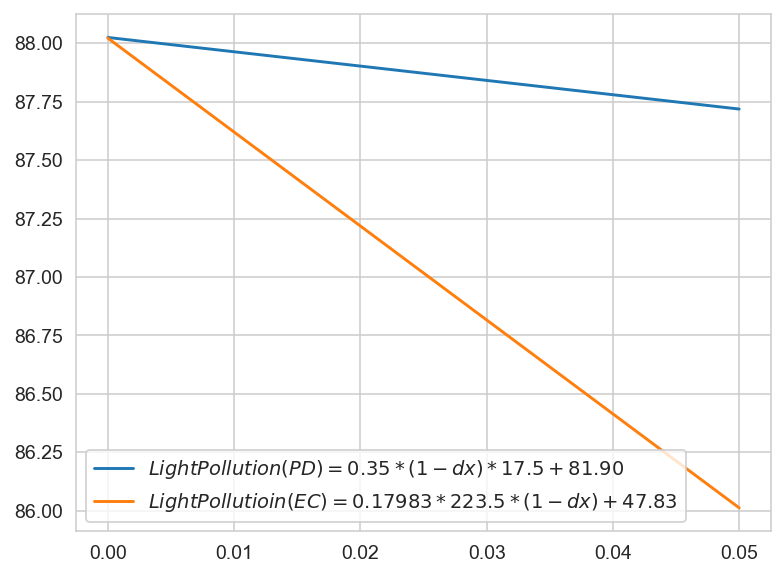

In [3]:

plt.figure(dpi=140)

dx = np.linspace(0,0.05,64)
def func(dx):
    return 0.35*(1-dx)*17.5+81.90



def func2(dx):
    return 0.17983*223.5*(1-dx)+47.83

plt.plot(dx,func(dx),label='$LightPollution(PD)=0.35*(1-dx)*17.5+81.90$')
plt.plot(dx,func2(dx),label='$LightPollutioin(EC) = 0.17983*223.5*(1-dx)+47.83$')
plt.legend()
plt.show()
